# **CartPole-v0**

**Video link for explaination(Please use Chrome)** :- https://iiitaphyd-my.sharepoint.com/:v:/g/personal/samanvaya_panda_research_iiit_ac_in/EQRiNIfc_PVJmLSjA6dccs0B2C-zuexdSdYnY8jjC2L3bg?e=wj49zu

This notebook consists of implementations of various agents for Cartpole enviroment of OpenAi Gym. Cartpole enviroment has an discrete action space(0 or 1). The Agent gains a reward of +1 if it was able to balance the pole else it recieves a reward of 0.


In [ ]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from matplotlib import pyplot as plt

**Creating Cartpole enviroment**

In [ ]:
ENV="CartPole-v0"
episodes=500

env=gym.make(ENV) 

## **Vanilla Policy gradient Agent**

A vanilla policy gradient agent perform default policy gradient updates to learn a policy.

In [ ]:
class VanillaPolicyAgent:
  def __init__(self, env):

    self.env=env
    self.state_shape=env.observation_space.shape 
    self.action_shape=env.action_space.n 
    self.gamma=0.99 
    self.alpha=1e-4 
    self.learning_rate=0.01 
    
    self.model=self.create_model() 
    
    self.states=[]
    self.gradients=[] 
    self.rewards=[]
    self.probs=[]
    self.policy_var=[]
    self.total_rewards=[]
  
  def create_model(self):

    model=Sequential()
    model.add(layers.Dense(24, input_shape=self.state_shape, activation="relu"))
    model.add(layers.Dense(12, activation="relu"))
    model.add(layers.Dense(self.action_shape, activation="softmax")) 
    model.compile(loss="categorical_crossentropy",
            optimizer=tf.keras.optimizers.Adam(lr=self.learning_rate))
        
    return model
  
  def set_parametes(self, state, action, action_prob, reward):

    encoded_action=np.zeros(self.action_shape)
    encoded_action[action] = 1
    self.gradients.append(encoded_action-action_prob)
    self.states.append(state)
    self.rewards.append(reward)
    self.probs.append(action_prob)

  def get_action(self, state):

    state=state.reshape([1, state.shape[0]])
    action_probability_distribution=self.model.predict(state).flatten()
    action=np.random.choice(self.action_shape,1,
                            p=action_probability_distribution)[0]

    return action, action_probability_distribution

  def get_discounted_rewards(self, rewards): 
    
    discounted_rewards=[]
    cumulative_total_return=0
    for reward in rewards[::-1]:      
      cumulative_total_return=(cumulative_total_return*self.gamma)+reward
      discounted_rewards.insert(0, cumulative_total_return)

    mean_rewards=np.mean(discounted_rewards)
    std_rewards=np.std(discounted_rewards)
    norm_discounted_rewards=(discounted_rewards-
                          mean_rewards)/(std_rewards+1e-5)
    
    return norm_discounted_rewards
  
  def update_policy(self):

    states = np.reshape(self.states, (len(self.states), len(self.states[0])))
    gradients=np.reshape(self.gradients, (len(self.gradients), len(self.gradients[0])))
    rewards=np.reshape(self.rewards, (len(self.rewards), 1))

    discounted_rewards=self.get_discounted_rewards(rewards)
    self.policy_var.append(np.var(discounted_rewards))
 
    gradients*=discounted_rewards
    gradients=self.alpha*np.vstack([gradients])+self.probs

    self.model.train_on_batch(states, gradients)
    self.states, self.probs, self.gradients, self.rewards=[], [], [], []

  def train(self, episodes):
    
    env=self.env
    total_rewards=np.zeros(episodes)

    for episode in range(episodes):
      state=env.reset()
      done=False          
      episode_reward=0 
      
      while not done:
        action, prob=self.get_action(state)
        next_state, reward, done, _=env.step(action)
        self.set_parametes(state, action, prob, reward)
        state=next_state
        episode_reward+=reward

        if done:
          self.update_policy()

      total_rewards[episode]=episode_reward
      if episode%25 == 0:
        print("For", episode, ": Reward =", episode_reward)
    self.total_rewards=total_rewards

  

**Training our Agent**

In [ ]:
vanilla_agent = VanillaPolicyAgent(env)
vanilla_agent.train(episodes)

For 0 : Reward = 14.0
For 25 : Reward = 21.0
For 50 : Reward = 57.0
For 75 : Reward = 200.0
For 100 : Reward = 200.0
For 125 : Reward = 150.0
For 150 : Reward = 200.0
For 175 : Reward = 200.0
For 200 : Reward = 200.0
For 225 : Reward = 132.0
For 250 : Reward = 67.0
For 275 : Reward = 164.0
For 300 : Reward = 200.0
For 325 : Reward = 193.0
For 350 : Reward = 183.0
For 375 : Reward = 200.0
For 400 : Reward = 200.0
For 425 : Reward = 63.0
For 450 : Reward = 200.0
For 475 : Reward = 200.0


**Plotting Results**

The following plot shows rewards obtained in each episode by the agent.

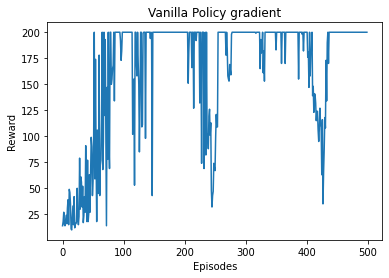

In [ ]:
plt.plot(vanilla_agent.total_rewards)
plt.title("Vanilla Policy gradient")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.show()

## **Policy Gradient with baselines**

The policy gradient with baseline agent uses a predefined baseline function. A baseline function is used to reduce the variance in gradient computation. We use the value function approximation of an agent as the baseline function. Value function approximation is considered a good baseline function because it gives an future estimate of the state value.

In [ ]:
class BaselineAgent:
  def __init__(self, env):

    self.env=env
    self.state_shape=env.observation_space.shape 
    self.action_shape=env.action_space.n 
    self.gamma=0.99 
    self.alpha=1e-4 
    self.learning_rate=0.01 
    
    self.model=self.create_model() 
    
    self.states=[]
    self.gradients=[] 
    self.rewards=[]
    self.probs=[]
    self.policy_var=[]
    self.total_rewards=[]
  
  def create_model(self):

    model=Sequential()
    model.add(layers.Dense(24, input_shape=self.state_shape, activation="relu"))
    model.add(layers.Dense(12, activation="relu"))
    model.add(layers.Dense(self.action_shape, activation="softmax")) 
    model.compile(loss="categorical_crossentropy",
            optimizer=tf.keras.optimizers.Adam(lr=self.learning_rate))
        
    return model
  
  def set_parametes(self, state, action, action_prob, reward):

    encoded_action=np.zeros(self.action_shape)
    encoded_action[action] = 1
    self.gradients.append(encoded_action-action_prob)
    self.states.append(state)
    self.rewards.append(reward)
    self.probs.append(action_prob)

  def action_probability(self, state):
    
    action_probability_distribution=self.model.predict(state).flatten()
    action_probability_distribution/=np.sum(action_probability_distribution)
    return action_probability_distribution

  def get_action(self, state):

    state=state.reshape([1, state.shape[0]])
    action_probability_distribution = self.action_probability(state)
    action=np.random.choice(self.action_shape,1,
                            p=action_probability_distribution)[0]

    return action, action_probability_distribution

  def get_discounted_rewards(self, rewards, states):
    rewards = rewards[::-1] 
    discounted_rewards=[]
    cumulative_total_return=0
    action_probability_distribution = self.action_probability(states)
    for i in range(len(rewards)):      
      cumulative_total_return=(cumulative_total_return*self.gamma)+rewards[i]
      #Baseline
      cumulative_total_return*= (1-action_probability_distribution[i])
      
      discounted_rewards.insert(0, cumulative_total_return)


    mean_rewards = np.mean(discounted_rewards)
    std_rewards=np.std(discounted_rewards)
    norm_discounted_rewards=(discounted_rewards-
                          mean_rewards)/(std_rewards+1e-5)
    
    return norm_discounted_rewards 

  def update_policy(self, i):

    states = np.vstack(self.states)
    gradients = np.vstack(self.gradients)
    rewards = np.vstack(self.rewards)

    discounted_rewards=self.get_discounted_rewards(rewards, states)
    self.policy_var.append(np.var(discounted_rewards))
    gradients*=discounted_rewards
    gradients=self.alpha*np.vstack([gradients])+self.probs
    self.model.train_on_batch(states, gradients)

    self.states, self.probs, self.gradients, self.rewards=[], [], [], []

  def train(self, episodes):
    
    env=self.env
    total_rewards=np.zeros(episodes)

    for episode in range(episodes):
      state=env.reset()
      done=False          
      episode_reward=0 
      
      while not done:
        action, prob=self.get_action(state)
        next_state, reward, done, _=env.step(action)
        self.set_parametes(state, action, prob, reward)
        state=next_state
        episode_reward+=reward

        if done:
            self.update_policy(episode)

      total_rewards[episode]=episode_reward
      if episode%25 == 0:
        print("For", episode, ": Reward =", episode_reward)
    self.total_rewards=total_rewards

  

**Training our agent**

In [ ]:
baseline_agent = BaselineAgent(env)
baseline_agent.train(episodes)

For 0 : Reward = 15.0
For 25 : Reward = 20.0
For 50 : Reward = 34.0
For 75 : Reward = 93.0
For 100 : Reward = 20.0
For 125 : Reward = 81.0
For 150 : Reward = 96.0
For 175 : Reward = 86.0
For 200 : Reward = 130.0
For 225 : Reward = 123.0
For 250 : Reward = 200.0
For 275 : Reward = 200.0
For 300 : Reward = 200.0
For 325 : Reward = 200.0
For 350 : Reward = 200.0
For 375 : Reward = 200.0
For 400 : Reward = 200.0
For 425 : Reward = 200.0
For 450 : Reward = 200.0
For 475 : Reward = 200.0


**Plotting Results**

The following plot shows rewards obtained in each episode by the agent.

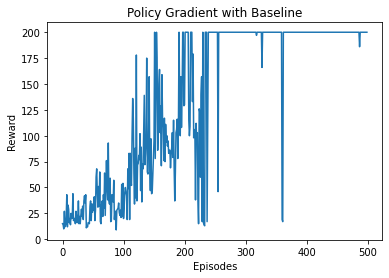

In [ ]:
plt.plot(baseline_agent.total_rewards)
plt.title("Policy Gradient with Baseline")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.show()

**Comparision between variance of Vanilla policy gradient and policy gradient with baseline**

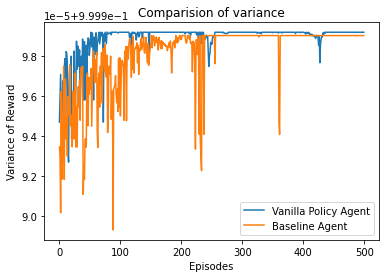

In [ ]:
plt.plot(vanilla_agent.policy_var, label="Vanilla Policy Agent")
plt.plot(baseline_agent.policy_var, label="Baseline Agent")
plt.title("Comparision of variance")
plt.xlabel("Episodes")
plt.ylabel("Variance of Reward")
plt.legend()
plt.show()

From the above plot we observe that policy gradient with baseline agent receives rewards that have less variance compared to a vanilla policy gradient agent. Hence, our baseline is able to reduce variance as it was expected to do so.

## **Actor-Critic Method**

The actor-critic method uses an additional network for function approximation compared to previous to methods. 

In [ ]:
class ActorCriticAgent:
  def __init__(self, env):
    self.env = env
    self.num_states = env.observation_space.shape[0]
    self.num_actions = env.action_space.n
    self.gamma = 0.99
    self.tau = 0.005

    self.max_states = 100000
    self.states = np.zeros((self.max_states, self.num_states))
    self.actions = np.zeros((self.max_states, self.num_actions))
    self.reward = np.zeros((self.max_states, 1))
    self.next_state = np.zeros((self.max_states, self.num_states))
    self.total_rewards = []
    self.counter = 0

    self.actor_model = self.create_actor_model()
    self.target_actor = self.create_actor_model()
    self.target_actor.set_weights(self.actor_model.get_weights())

    self.critic_model = self.create_critic_model() 
    self.target_critic = self.create_critic_model() 
    self.target_critic.set_weights(self.critic_model.get_weights())
    
    self.actor_optimizer = tf.keras.optimizers.Adam(0.001)
    self.critic_optimizer = tf.keras.optimizers.Adam(0.002)

  def create_actor_model(self):

      model=Sequential()
      model.add(layers.Dense(256, input_shape=self.num_states, activation="relu"))
      model.add(layers.Dense(256, activation="relu"))
      model.add(layers.Dense(self.num_actions, activation="softmax"))     
      return model

  def create_critic_model(self):
      state_input = layers.Input(shape=(self.num_states))
      state_out = layers.Dense(16, activation="relu")(state_input)
      state_out = layers.Dense(32, activation="relu")(state_out)

      action_input = layers.Input(shape=(self.num_actions))
      action_out = layers.Dense(32, activation="relu")(action_input)

      concat = layers.Concatenate()([state_out, action_out])

      out = layers.Dense(256, activation="relu")(concat)
      out = layers.Dense(256, activation="relu")(out)
      outputs = layers.Dense(self.num_actions, activation="softmax")(out)

      model = tf.keras.Model([state_input, action_input], outputs)

      return model

  def set_parameters(self, tuple):
    i = self.counter % self.max_states
    self.states[i] = tuple[0]
    self.actions[i] = tuple[1]
    self.reward[i] = tuple[2]
    self.next_state[i] = tuple[3]
    self.counter += 1
  
  def update(self, state_batch, action_batch, reward_batch, next_state_batch):
    #Critic Model
    with tf.GradientTape() as tape:
        target_actions = self.target_actor(next_state_batch, training=True)
        y = reward_batch + self.gamma * self.target_critic(
            [next_state_batch, target_actions], training=True
        )
        critic_value = self.critic_model([state_batch, action_batch], training=True)
        critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

    critic_grad = tape.gradient(critic_loss, self.critic_model.trainable_variables)
    self.critic_optimizer.apply_gradients(
        zip(critic_grad, self.critic_model.trainable_variables)
    )

    #Actor Model
    with tf.GradientTape() as tape:
        actions = self.actor_model(state_batch, training=True)
        critic_value = self.critic_model([state_batch, actions], training=True)
        actor_loss = -tf.math.reduce_mean(critic_value)

    actor_grad = tape.gradient(actor_loss, self.actor_model.trainable_variables)
    self.actor_optimizer.apply_gradients(
        zip(actor_grad, self.actor_model.trainable_variables)
    )

  def normalize_reward(self, rewards):
    
    mean_rewards=np.mean(rewards)
    std_rewards=np.std(rewards)
    norm_discounted_rewards=(rewards-
                          mean_rewards)/(std_rewards+1e-5)
    
    return norm_discounted_rewards

  def learn(self):
    record_range = min(self.counter, self.max_states)
    batch_indices = np.random.choice(record_range, 32)

    state_batch = self.states[batch_indices]
    action_batch = self.actions[batch_indices]
    reward_batch = self.normalize_reward(self.reward)[batch_indices]
    # reward_batch = tf.cast(reward_batch, dtype=tf.float32)
    next_state_batch = self.next_state[batch_indices]

    self.update(state_batch, action_batch, reward_batch, next_state_batch)

  def update_target(self, target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

  def action_probability(self, state):
    action_probability_distribution=self.actor_model.predict(state).flatten()
    action_probability_distribution/=np.sum(action_probability_distribution)
    
    return action_probability_distribution

  def policy(self, state):
    action_probability_distribution = self.action_probability(state)
    action=np.random.choice(self.num_actions,1,
                            p=action_probability_distribution)[0]
    return action


  def train_agent(self, episodes):
    total_rewards = []
    env = self.env
    
    for ep in range(episodes):

      cur_state = env.reset()
      episode_reward = 0
      done = False
      while not done:

          prev_state = np.expand_dims(cur_state, 0)

          action = self.policy(prev_state)
          # Recieve state and reward from environment.
          state, reward, done, info = env.step(action)

          self.set_parameters((prev_state, action, reward, state))
          episode_reward += reward

          self.learn()
          self.update_target(self.target_actor.variables, self.actor_model.variables, self.tau)
          self.update_target(self.target_critic.variables, self.critic_model.variables, self.tau)

          cur_state = state

      total_rewards.append(episode_reward)
      if ep%25 == 0:
        print("Episode :", ep, "Reward =", total_rewards[-1])
    self.total_rewards = total_rewards


**Training our Agent**

In [ ]:
actor_critic_agent = ActorCriticAgent(env)
actor_critic_agent.train_agent(2000)

Episode : 0 Reward = 14.0
Episode : 25 Reward = 16.0
Episode : 50 Reward = 20.0
Episode : 75 Reward = 10.0
Episode : 100 Reward = 23.0
Episode : 125 Reward = 22.0
Episode : 150 Reward = 21.0
Episode : 175 Reward = 44.0
Episode : 200 Reward = 20.0
Episode : 225 Reward = 26.0
Episode : 250 Reward = 23.0
Episode : 275 Reward = 11.0
Episode : 300 Reward = 60.0
Episode : 325 Reward = 38.0
Episode : 350 Reward = 13.0
Episode : 375 Reward = 13.0
Episode : 400 Reward = 20.0
Episode : 425 Reward = 22.0
Episode : 450 Reward = 28.0
Episode : 475 Reward = 45.0
Episode : 500 Reward = 33.0
Episode : 525 Reward = 13.0
Episode : 550 Reward = 11.0
Episode : 575 Reward = 17.0
Episode : 600 Reward = 16.0
Episode : 625 Reward = 9.0
Episode : 650 Reward = 29.0
Episode : 675 Reward = 22.0
Episode : 700 Reward = 28.0
Episode : 725 Reward = 21.0
Episode : 750 Reward = 14.0
Episode : 775 Reward = 16.0
Episode : 800 Reward = 25.0
Episode : 825 Reward = 31.0
Episode : 850 Reward = 14.0
Episode : 875 Reward = 42.

**Plotting Results**

The following plot shows rewards obtained in each episode by the agent.

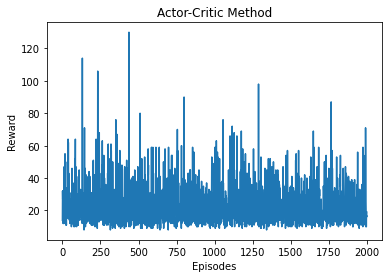

In [ ]:
plt.plot(actor_critic_agent.total_rewards)
plt.title("Actor-Critic Method")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.show()